In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn import datasets

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.cluster import KMeans

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score


Challenge 1 - Import and Describe the Dataset
In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is here.

In [7]:
# loading the data:
customers = pd.read_csv('Wholesale customers data.csv')

Explore the dataset with mathematical and visualization techniques. What do you find?
Checklist:

What does each column mean?
Any categorical data to convert?
Any missing data to remove?
Column collinearity - any high correlations?
Descriptive statistics - any outliers to remove?
Column-wise data distribution - is the distribution skewed?
Etc.
Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the Pareto principle. Check if this dataset displays this characteristic.

In [8]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [9]:
customers.isna().sum()


Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [10]:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

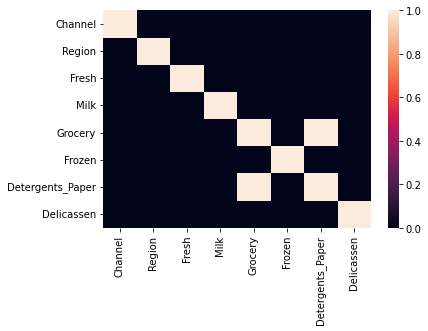

In [11]:
sns.heatmap(customers.corr()>0.8);


In [12]:
for col in customers:
    q25 = np.quantile(customers[col], 0.25)
    q75 = np.quantile(customers[col], 0.75)
    IQR = q75 - q25
    mask = (customers[col] > (q75 + 3 * IQR)) | (customers[col] < (q25 - 3 * IQR))
    out_customers = customers[mask]

In [13]:
out_customers

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
2,2,3,6353,8808,7684,2405,3516,7844
23,2,3,26373,36423,22019,5154,4337,16523
47,2,3,44466,54259,55571,7782,24171,6465
71,1,3,18291,1266,21042,5373,4173,14472
87,1,3,43265,5025,8117,6312,1579,14351
171,2,3,200,25862,19816,651,8773,6250
181,1,3,112151,29627,18148,16745,4948,8550
183,1,3,36847,43950,20170,36534,239,47943
202,1,1,25203,11487,9490,5065,284,6854
218,2,1,18,7504,15205,1285,4797,6372


In [14]:
customers[['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper', 'Delicassen']].sum()
total_sales = np.sum(customers[['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper', 'Delicassen']].sum())
total_sales

14619500

In [15]:
customers[['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper', 'Delicassen']].sum()/total_sales


Fresh               0.361170
Milk                0.174449
Grocery             0.239308
Frozen              0.092455
Detergents_Paper    0.086724
Delicassen          0.045894
dtype: float64

In [16]:
total_purchase = pd.DataFrame(customers[['Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper', 'Delicassen']].sum(axis=1).sort_values(ascending=False))
total_purchase

,0
85,199891
47,192714
181,190169
183,185683
61,165881
...,...
131,3730
355,3485
98,2476
97,2158


In [18]:
total_purchase['Accumulated Cust. Purchase'] = np.cumsum(total_purchase[0])


In [19]:
(total_purchase['Accumulated Cust. Purchase']/total_purchase[0].sum()).iloc[86] 


0.4258362461096481

Challenge 2 - Data Cleaning and Transformation
If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [20]:
customers = customers[~mask]
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451


Challenge 3 - Data Preprocessing
One problem with the dataset is the value ranges are remarkably different across various categories (e.g. Fresh and Grocery compared to Detergents_Paper and Delicassen). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into feature scaling. Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

We will use the StandardScaler from sklearn.preprocessing and scale our data. Read more about StandardScaler here.
After scaling your data, assign the transformed data to a new variable customers_scale.

In [21]:
from sklearn.preprocessing import StandardScaler

# Your code here:

cust_scale = StandardScaler()
cust_scale.fit(customers)

customers_scale = pd.DataFrame(cust_scale.transform(customers), columns=customers.columns)
customers_scale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.462425,0.592898,0.097337,0.655052,-0.012634,-0.596709,-0.030350,0.081700
1,1.462425,0.592898,-0.391300,0.678808,0.205122,-0.257900,0.101606,0.466184
2,-0.683796,0.592898,0.149231,-0.650005,-0.375017,0.758087,-0.492302,0.476718
3,1.462425,0.592898,0.963337,0.000055,-0.052019,0.213323,-0.221569,3.458663
4,1.462425,0.592898,-0.186163,0.439548,-0.276827,-0.497780,-0.217732,0.180894


Challenge 3 - Data Clustering with K-Means
Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the .fit method, there is an attribute called labels_ which is the cluster number assigned to each data record. What you can do is to assign these labels back to customers in a new column called customers['labels']. Then you'll see the cluster results of the original data.

In [23]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

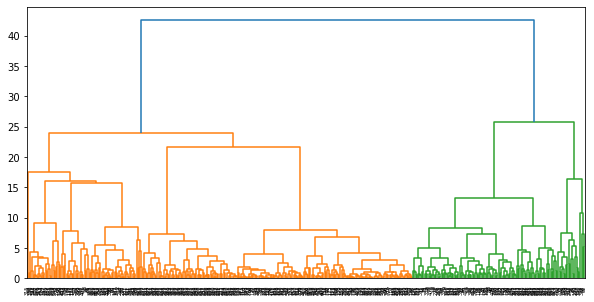

In [24]:
fig = plt.figure(figsize = (10, 5))
customers_dendogram = dendrogram(linkage(customers_scale, method = 'ward'))

In [25]:
km_fit_customers = KMeans(n_clusters=5)
km_fit_customers.fit(customers_scale)

KMeans(n_clusters=5)

In [26]:
customers["labels"] = [str(x) for x in km_fit_customers.labels_]


In [27]:
customers['labels'].value_counts()


0    163
1    118
2     83
3     57
4      9
Name: labels, dtype: int64

Challenge 4 - Data Clustering with DBSCAN
Now let's cluster the data using DBSCAN. Use DBSCAN(eps=0.5) to initiate the model, then fit your scaled data. In the data returned from the .fit method, assign the labels_ back to customers['labels_DBSCAN']. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [28]:
from sklearn.cluster import DBSCAN

cluster = DBSCAN(eps=0.5)
cluster.fit(customers_scale)

customers['labels_DBSCAN'] = [str(x) for x in cluster.labels_]

In [29]:
customers['labels_DBSCAN'].value_counts()

-1    317
0     103
1      10
Name: labels_DBSCAN, dtype: int64

Challenge 5 - Compare K-Means with DBSCAN
Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using labels and another using labels_DBSCAN. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

Detergents_Paper as X and Milk as y
Grocery as X and Fresh as y
Frozen as X and Delicassen as y
Visualize Detergents_Paper as X and Milk as y by labels and labels_DBSCAN respectively



/Users/camila/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


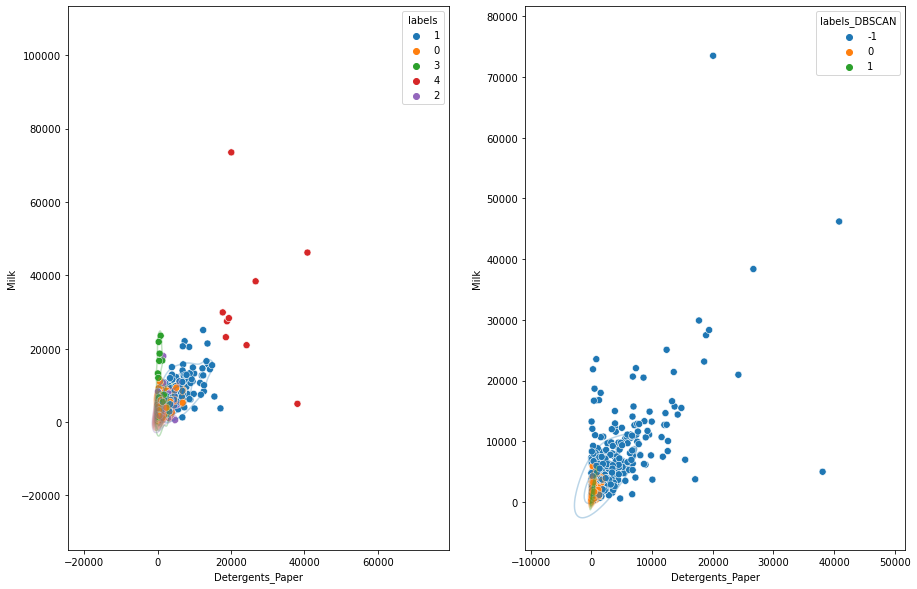

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [30]:
fig, ax= plt.subplots(1, 2, figsize=(15 , 10))

plt.figure(figsize=(10, 10))
sns.kdeplot(
    data=customers, 
    x="Detergents_Paper", y="Milk", 
    hue="labels", alpha = 0.3,
    ax=ax[0])

sns.scatterplot(
    data=customers, x="Detergents_Paper", y="Milk",
    hue="labels", s = 50,
    ax=ax[0])
ax[0].axis("equal")

plt.figure(figsize=(10, 10))
sns.kdeplot(
    data=customers, 
    x="Detergents_Paper", y="Milk", 
    hue="labels_DBSCAN", alpha = 0.3,
    ax=ax[1])

sns.scatterplot(
    data=customers, 
    x="Detergents_Paper", y="Milk", 
    hue="labels_DBSCAN", s = 50,
    ax=ax[1])
ax[1].axis("equal");

Visualize Grocery as X and Fresh as y by labels and labels_DBSCAN respectively

/Users/camila/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


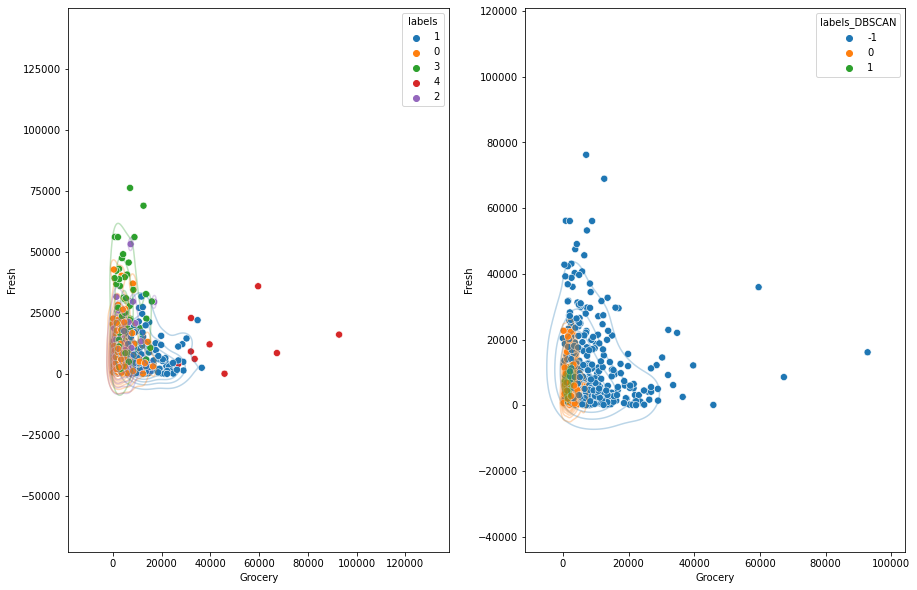

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [31]:
fig, ax= plt.subplots(1, 2, figsize=(15 , 10))

plt.figure(figsize=(10, 10))
sns.kdeplot(
    data=customers, 
    x="Grocery", y="Fresh", 
    hue="labels", alpha = 0.3,
    ax=ax[0])

sns.scatterplot(
    data=customers, x="Grocery", y="Fresh",
    hue="labels", s = 50,
    ax=ax[0])
ax[0].axis("equal")

plt.figure(figsize=(10, 10))
sns.kdeplot(
    data=customers, 
    x="Grocery", y="Fresh", 
    hue="labels_DBSCAN", alpha = 0.3,
    ax=ax[1])

sns.scatterplot(
    data=customers, 
    x="Grocery", y="Fresh", 
    hue="labels_DBSCAN", s = 50,
    ax=ax[1])
ax[1].axis("equal");

Visualize Frozen as X and Delicassen as y by labels and labels_DBSCAN respectively

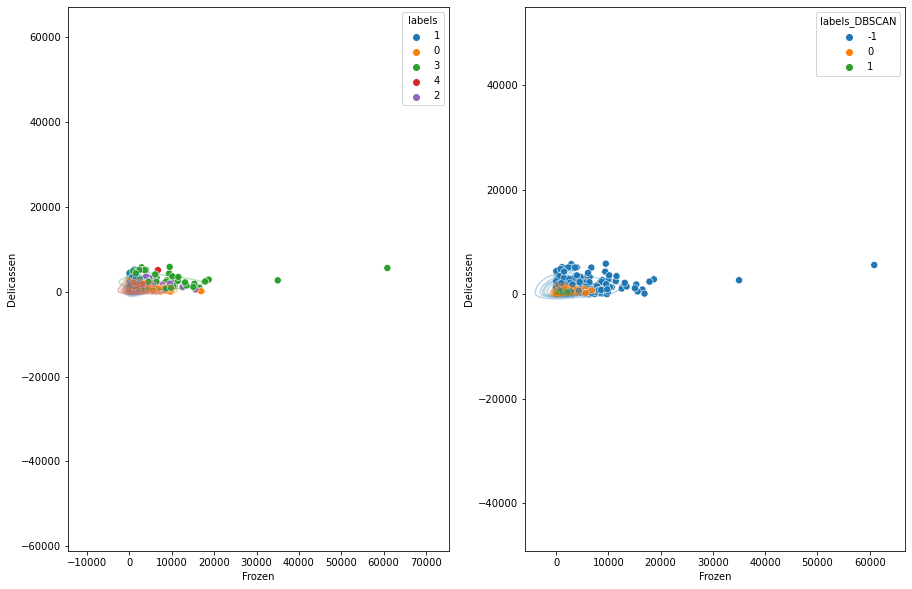

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [34]:
fig, ax= plt.subplots(1, 2, figsize=(15 , 10))

plt.figure(figsize=(10, 10))
sns.kdeplot(
    data=customers, 
    x="Frozen", y="Delicassen", 
    hue="labels", alpha = 0.3,
    ax=ax[0])

sns.scatterplot(
    data=customers, x="Frozen", y="Delicassen",
    hue="labels", s = 50,
    ax=ax[0])
ax[0].axis("equal")

plt.figure(figsize=(10, 10))
sns.kdeplot(
    data=customers, 
    x="Frozen", y="Delicassen", 
    hue="labels_DBSCAN", alpha = 0.3,
    ax=ax[1])

sns.scatterplot(
    data=customers, 
    x="Frozen", y="Delicassen", 
    hue="labels_DBSCAN", s = 50,
    ax=ax[1])
ax[1].axis("equal");

Let's use a groupby to see how the mean differs between the groups. Group customers by labels and labels_DBSCAN respectively and compute the means for all columns.

In [35]:
grouped_lab_kmeans = customers.groupby('labels').mean()
grouped_lab_kmeans

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
labels,,,,,,,,
0,1.006135,3.000000,9453.693252,2565.687117,3240.190184,2290.625767,748.092025,746.423313
1,2.000000,2.669492,7449.194915,8913.466102,14427.830508,1307.516949,6289.983051,1346.966102
2,1.048193,1.313253,10628.759036,2880.807229,3984.265060,2938.746988,891.518072,928.337349
3,1.087719,2.771930,27186.614035,5688.017544,5441.631579,8245.701754,847.473684,2713.947368
4,2.000000,2.444444,12798.111111,32536.222222,47755.333333,2529.333333,24953.444444,2551.444444


In [36]:
grouped_lab_dbscan = customers.groupby('labels_DBSCAN').mean()
grouped_lab_dbscan

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
labels_DBSCAN,,,,,,,,
-1,1.432177,2.44164,12907.870662,6704.470032,9621.643533,3381.621451,3667.044164,1471.977918
0,1.000000,3.00000,7829.009709,1785.805825,2275.339806,1731.436893,442.203883,624.106796
1,1.000000,1.00000,6878.100000,1689.100000,1687.900000,1403.200000,304.000000,441.900000


Which algorithm appears to perform better?



In [37]:

variance_kmeans = (grouped_lab_kmeans.max() - grouped_lab_kmeans.min()).reset_index()
variance_kmeans.sort_values(0, ascending=False) 

,index,0
4,Grocery,44515.143149
3,Milk,29970.535106
6,Detergents_Paper,24205.352420
2,Fresh,19737.419120
5,Frozen,6938.184805
7,Delicassen,1967.524056
1,Region,1.686747
0,Channel,0.993865


In [38]:
variance_dbscan = (grouped_lab_dbscan.max() - grouped_lab_dbscan.min()).reset_index()
variance_dbscan.sort_values(0, ascending=False) 

,index,0
4,Grocery,7933.743533
2,Fresh,6029.770662
3,Milk,5015.370032
6,Detergents_Paper,3363.044164
5,Frozen,1978.421451
7,Delicassen,1030.077918
1,Region,2.000000
0,Channel,0.432177


In [47]:
variances = pd.concat([variance_kmeans, variance_dbscan], axis=1)
variances.columns = ['Category', 'Variance KMeans', 'Droped', 'Variance DBScan']
variances.drop('Droped', axis=1, inplace=True)
variances = variances.set_index('Category')
variances

,Variance KMeans,Variance DBScan
Category,,
Channel,0.993865,0.432177
Region,1.686747,2.000000
Fresh,19737.419120,6029.770662
Milk,29970.535106,5015.370032
Grocery,44515.143149,7933.743533
Frozen,6938.184805,1978.421451
Detergents_Paper,24205.352420,3363.044164
Delicassen,1967.524056,1030.077918


In [41]:
variances['Diff of vars'] = variances['Variance KMeans'] - variances['Variance DBScan']
variances.sort_values('Diff of vars', ascending=False)['Diff of vars'].reset_index()

,Category,Diff of vars
0,Grocery,36581.399616
1,Milk,24955.165074
2,Detergents_Paper,20842.308256
3,Fresh,13707.648457
4,Frozen,4959.763354
5,Delicassen,937.446138
6,Channel,0.561688
7,Region,-0.313253


Bonus Challenge 2 - Changing K-Means Number of Clusters
As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the n_clusters param (if you don't supply n_clusters, the algorithm will use 8 by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read here). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [48]:
customers_scale_bonus = customers_scale.copy()
customers_bonus = customers.copy()

def n_kmeans(dataframe):
    clusters = [2, 3, 4, 5, 6, 7]
    for k in clusters:
        km_fit_customers = KMeans(n_clusters=k)
        km_fit_customers.fit(dataframe)
        customers_bonus[f"labels_bonus_k_{k}"] = [str(x) for x in km_fit_customers.labels_]
n_kmeans(customers_scale_bonus)


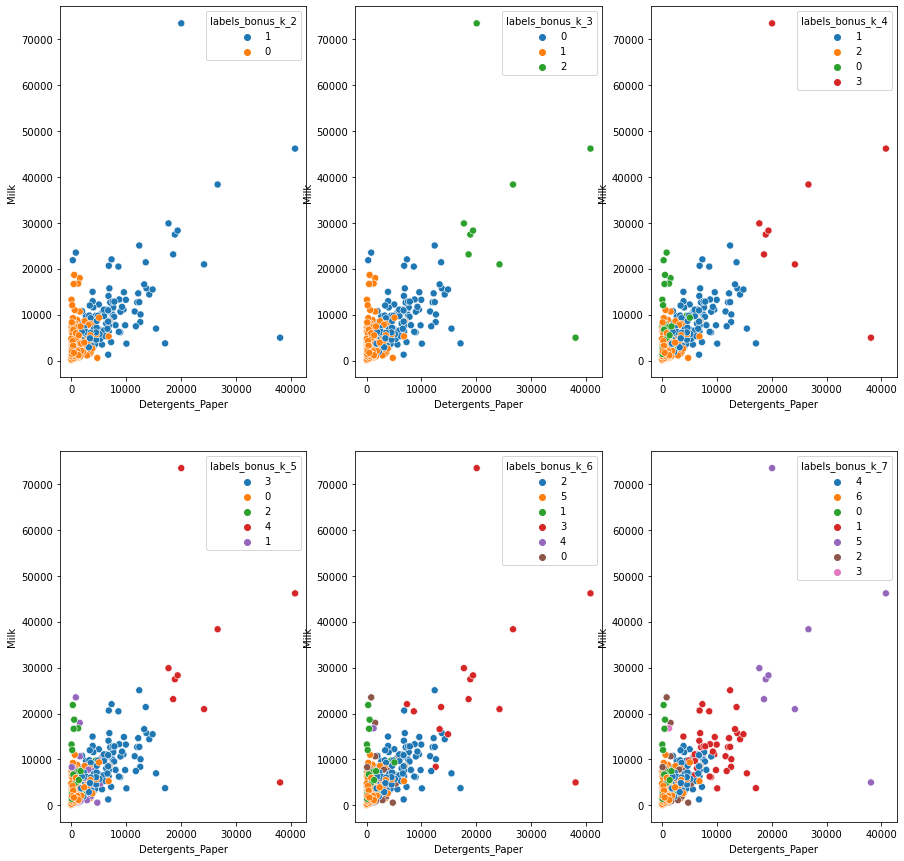

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [49]:

fig, ax = plt.subplots(2, 3, figsize=(15, 15))


plt.figure(figsize=(10, 10))
sns.scatterplot(data=customers_bonus, x="Detergents_Paper", y="Milk", hue="labels_bonus_k_2", s = 50, ax=ax[0][0]);

plt.figure(figsize=(10, 10))
sns.scatterplot(data=customers_bonus, x="Detergents_Paper", y="Milk", hue="labels_bonus_k_3", s = 50, ax=ax[0][1]);

plt.figure(figsize=(10, 10))
sns.scatterplot(data=customers_bonus, x="Detergents_Paper", y="Milk", hue="labels_bonus_k_4", s = 50, ax=ax[0][2]);


plt.figure(figsize=(10, 10))
sns.scatterplot(data=customers_bonus, x="Detergents_Paper", y="Milk", hue="labels_bonus_k_5", s = 50, ax=ax[1][0]);

plt.figure(figsize=(10, 10))
sns.scatterplot(data=customers_bonus, x="Detergents_Paper", y="Milk", hue="labels_bonus_k_6", s = 50, ax=ax[1][1]);

plt.figure(figsize=(10, 10))
sns.scatterplot(data=customers_bonus, x="Detergents_Paper", y="Milk", hue="labels_bonus_k_7", s = 50, ax=ax[1][2]);


Bonus Challenge 3 - Changing DBSCAN eps and min_samples
Experiment changing the eps and min_samples params for DBSCAN. See how the results differ with scatter plot visualization.

In [50]:
customers_bonus2 = customers.drop(['labels', 'labels_DBSCAN'], axis=1)
customers_scale_bonus2 = customers_scale.copy()
# Your code here

from sklearn.neighbors import NearestNeighbors

neighbors = int(len(customers_bonus2.columns) * 2)
neighbors
16
nbrs = NearestNeighbors(n_neighbors=neighbors)
nbrs.fit(customers_scale_bonus2)
NearestNeighbors(n_neighbors=16)

distances, indices = nbrs.kneighbors(customers_scale_bonus2)
tb_distances = pd.DataFrame(distances)
tb_distances.columns = ["N_" + str(i) for i in range(neighbors)]
tb_distances.head()

,N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12,N_13,N_14,N_15
0,0.0,0.501348,0.752848,0.801347,0.839418,0.845036,0.851050,0.926438,0.965980,0.995758,1.004125,1.096290,1.145085,1.172740,1.179693,1.186411
1,0.0,0.589505,0.603642,0.628760,0.644277,0.668025,0.710556,0.740386,0.752848,0.756644,0.801568,0.812743,0.848919,0.881440,0.954624,0.971524
2,0.0,0.458154,0.772518,0.798538,0.832216,0.840700,0.921249,0.965770,0.989541,1.009321,1.029235,1.060365,1.076131,1.097860,1.103091,1.103639
3,0.0,1.271556,1.876283,2.008964,2.281777,2.294301,2.363359,2.507279,2.526386,2.567511,2.593251,2.599001,2.722629,2.751905,2.785504,2.808249
4,0.0,0.501348,0.657304,0.676374,0.756644,0.760846,0.774601,0.947142,0.999062,1.015337,1.025513,1.055147,1.068149,1.089337,1.097276,1.116121


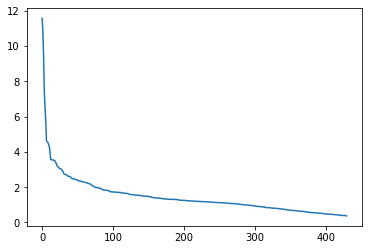

In [51]:
distance_desc = sorted(distances[:,-1], reverse=True)
plt.plot(distance_desc);

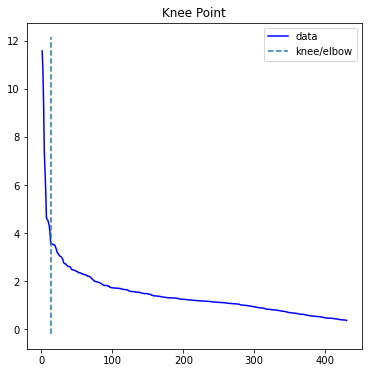

In [52]:
from kneed import KneeLocator

kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc,
                      S=2,
                      curve="convex",
                      direction="decreasing")
kneedle.plot_knee();